In [248]:
import numpy as np
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy import stats

In [228]:
# Load data
df = pd.read_csv('../data/emb.csv')
embeddings = [f'd_{i+1}' for i in range(320)]


In [229]:
df.describe().T.sort_values('std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
syndrome_id,1116.0,2.590802e+08,1.423676e+08,1.001809e+08,1.006104e+08,3.000000e+08,3.000001e+08,7.000182e+08
image_id,1116.0,3.463366e+05,3.735809e+05,2.480000e+02,1.046275e+04,2.199600e+04,7.563098e+05,8.120030e+05
subject_id,1116.0,3.320674e+05,3.620915e+05,9.600000e+01,8.794000e+03,3.345750e+04,7.387332e+05,7.546430e+05
d_297,1116.0,-6.501462e-02,1.577003e+00,-7.986729e+00,-1.075919e+00,4.052253e-02,1.022425e+00,4.255168e+00
d_260,1116.0,-3.151367e-01,1.405771e+00,-4.828587e+00,-1.266311e+00,-3.461358e-01,6.808401e-01,3.597312e+00
...,...,...,...,...,...,...,...,...
d_139,1116.0,3.084558e-01,1.017479e+00,-2.937943e+00,-4.098545e-01,2.759899e-01,1.016097e+00,3.829202e+00
d_190,1116.0,1.281268e-01,1.007568e+00,-2.879861e+00,-5.211167e-01,9.279779e-02,8.016625e-01,4.003929e+00
d_217,1116.0,2.832597e-01,9.928834e-01,-3.008166e+00,-3.954456e-01,3.213828e-01,9.576807e-01,3.964838e+00
d_318,1116.0,-5.238706e-03,9.906980e-01,-3.288884e+00,-6.663472e-01,4.190588e-02,6.795008e-01,2.797920e+00


In [230]:
null_sum = {'emb':[], 'sum_null':[]}
for i in embeddings:
    null_sum['emb'].append(i)
    null_sum['sum_null'].append(df[i].isnull().sum())
df_null = pd.DataFrame(null_sum)
df_null.sort_values('sum_null', ascending=False).T


,280,281,282,283,284,285,286,287,272,273,...,14,15,0,1,2,3,4,5,6,7
emb,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_273,d_274,...,d_15,d_16,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8
sum_null,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [231]:
#shapiro test to check normality of embedding data
shapiro_test = {'emb':[], 'stat':[], 'p':[], 'is_normal':[]}
for i in embeddings:
    shapiro_test['emb'].append(i)
    stat, p = shapiro(df[i])
    shapiro_test['stat'].append(stat)
    shapiro_test['p'].append(p)
    if p < 0.05:
        shapiro_test['is_normal'].append(False)
    else:
        shapiro_test['is_normal'].append(True)
df_shapiro = pd.DataFrame(shapiro_test)
df_shapiro.sort_values('p', ascending=True).T

,296,254,46,48,253,188,149,286,283,273,...,301,39,228,263,203,100,135,295,29,79
emb,d_297,d_255,d_47,d_49,d_254,d_189,d_150,d_287,d_284,d_274,...,d_302,d_40,d_229,d_264,d_204,d_101,d_136,d_296,d_30,d_80
stat,0.987735,0.98977,0.990164,0.992058,0.993112,0.99323,0.994094,0.994366,0.994372,0.994712,...,0.999162,0.999165,0.999185,0.999205,0.99921,0.999222,0.999234,0.999316,0.999359,0.9994
p,0.0,0.000001,0.000001,0.00001,0.000048,0.000057,0.000216,0.000334,0.000337,0.000587,...,0.909659,0.910788,0.92018,0.928853,0.931148,0.935957,0.940651,0.96735,0.977546,0.984992
is_normal,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


<Axes: ylabel='is_normal'>

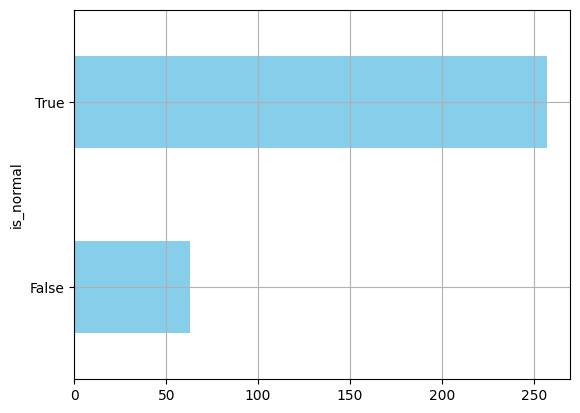

In [232]:
df_shapiro['is_normal'].value_counts().sort_values().plot(kind='barh', color='skyblue',grid=True)

In [233]:
df_shapiro['is_normal'].value_counts()/320

is_normal
True     0.803125
False    0.196875
Name: count, dtype: float64

In [236]:
# Since most of embeddings are normal, we will scale the data using standard scaler
from sklearn.preprocessing import StandardScaler
scaled_df = df.copy()
scaler = StandardScaler()
scaled_df[embeddings] = scaler.fit_transform(df[embeddings])

<Axes: xlabel='syndrome_id'>

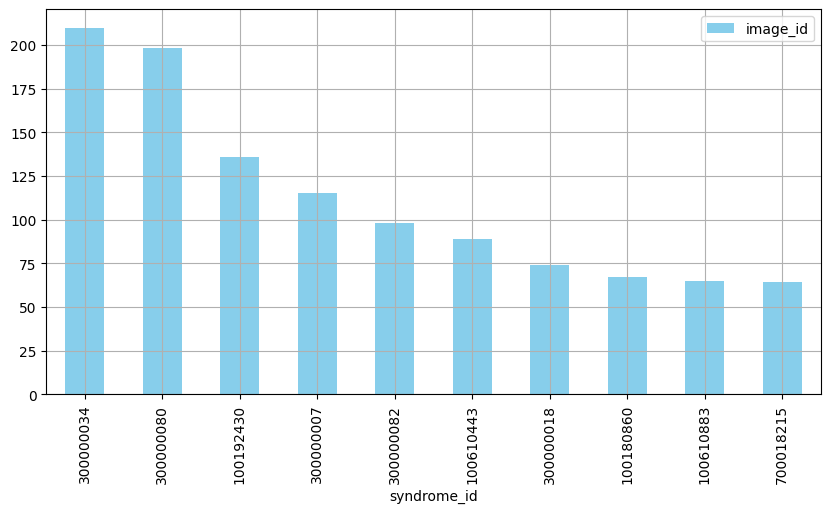

In [242]:
df[['syndrome_id', 'image_id']].groupby('syndrome_id').count().sort_values('image_id', ascending=False).plot(kind='bar', figsize=(10,5), color='skyblue', grid=True)

In [237]:
emb_tsne = {'c_1':[], 'c_2':[], 'syndrome_id':[]}
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(scaled_df[embeddings])
emb_tsne['c_1'] = embeddings_tsne[:,0]
emb_tsne['c_2'] = embeddings_tsne[:,1]
emb_tsne['syndrome_id'] = df['syndrome_id']
df_tsne = pd.DataFrame(emb_tsne)

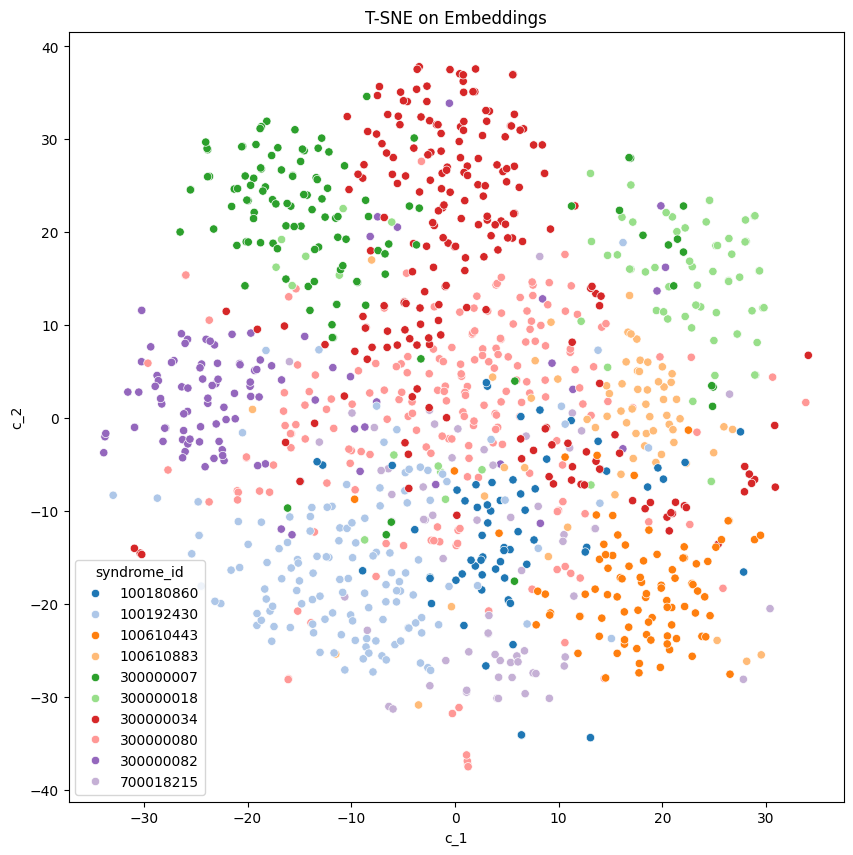

In [238]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_tsne, x='c_1', y='c_2', hue='syndrome_id', palette='tab20')
plt.title('T-SNE on Embeddings')
plt.show()

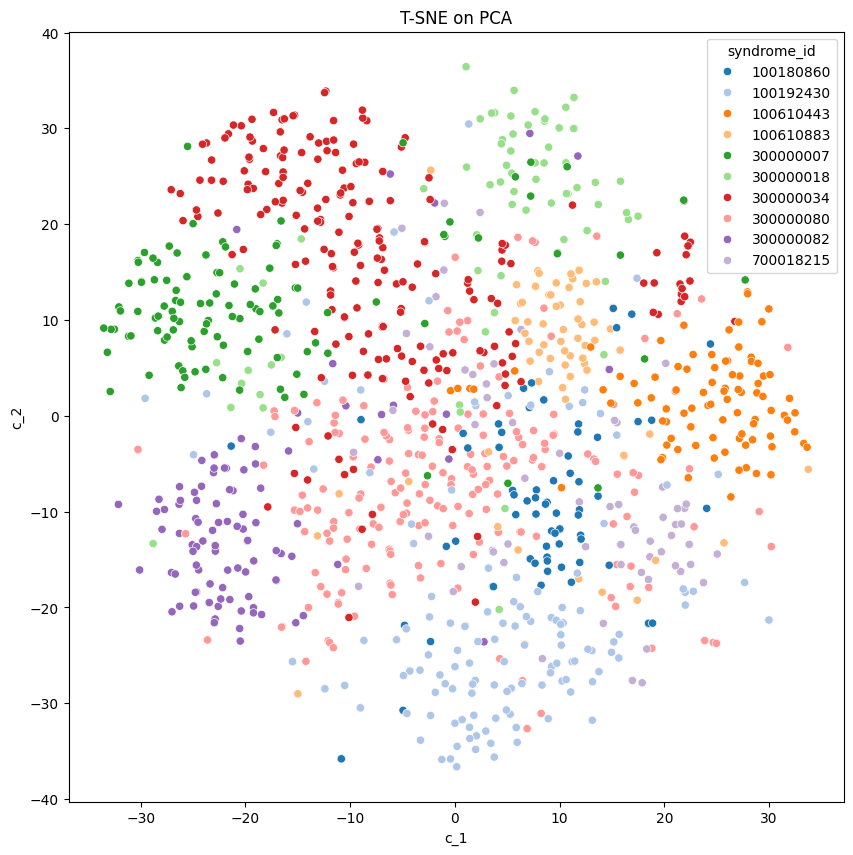

In [239]:
#apply PCA to reduce the dimensionality of the data for 40 components and then apply T-SNE to visualize the data in 2D
emb_tsne = {'c_1':[], 'c_2':[], 'syndrome_id':[]}
pca = PCA(n_components=40)
embeddings_pca = pca.fit_transform(scaled_df[embeddings])
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_pca)
emb_tsne['c_1'] = embeddings_tsne[:,0]
emb_tsne['c_2'] = embeddings_tsne[:,1]
emb_tsne['syndrome_id'] = df['syndrome_id']
df_tsne = pd.DataFrame(emb_tsne)
# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_tsne, x='c_1', y='c_2', hue='syndrome_id', palette='tab20')
plt.title('T-SNE on PCA')
plt.show()

In [253]:
# perform classification of the syndromes using the embedding data for each image using KNN, cross-validation of 10 folds and test 1 to 15 value of kk and use Cosine or Euclidean distance. Get the F1-Score and Top-k Accurancy.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# Split data
X = scaled_df[embeddings]
y = df['syndrome_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN
k_values = np.arange(1, 16)
distances = ['cosine', 'euclidean']
f1_scores = []
topk_scores = []

results = {'distance':[], 'k':[], 'f1':[], 'topk':[], 'auc':[]}

for distance in distances:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        f1 = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1_macro')
        topk = cross_val_score(knn, X_train, y_train, cv=10, scoring='top_k_accuracy')
        auc = cross_val_score(knn, X_train, y_train, cv=10, scoring='roc_auc_ovr')
        f1_scores.append(f1.mean())
        topk_scores.append(topk.mean())
        print(f'Distance: {distance}, K: {k}, F1: {f1.mean()}, Top-k: {topk.mean()}', 'AUC:', auc.mean())
        results['distance'].append(distance)
        results['k'].append(k)
        results['f1'].append(f1.mean())
        results['topk'].append(topk.mean())
        results['auc'].append(auc.mean())


Distance: cosine, K: 1, F1: 0.672381447653835, Top-k: 0.7365667915106118 AUC: 0.8232298072784883
Distance: cosine, K: 2, F1: 0.630141218437347, Top-k: 0.8273408239700373 AUC: 0.8794877661554825
Distance: cosine, K: 3, F1: 0.698173400634824, Top-k: 0.8328464419475654 AUC: 0.9059943399671886
Distance: cosine, K: 4, F1: 0.7046935588690857, Top-k: 0.8541573033707864 AUC: 0.9221269239630067
Distance: cosine, K: 5, F1: 0.7314484594125525, Top-k: 0.8654057428214731 AUC: 0.9301866890393378
Distance: cosine, K: 6, F1: 0.7211649461054842, Top-k: 0.8654057428214731 AUC: 0.9367393762363753
Distance: cosine, K: 7, F1: 0.7423597778092015, Top-k: 0.8754806491885143 AUC: 0.9401019476360435
Distance: cosine, K: 8, F1: 0.7491946776762208, Top-k: 0.8878651685393258 AUC: 0.9502153798491824
Distance: cosine, K: 9, F1: 0.7581148121540807, Top-k: 0.8923220973782773 AUC: 0.9525133582881955
Distance: cosine, K: 10, F1: 0.7536734884834794, Top-k: 0.8934706616729089 AUC: 0.9550323614888747
Distance: cosine, K: 1